In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, IDF, HashingTF, StopWordsRemover, CountVectorizer
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col, lower, regexp_replace, udf, when
from pyspark.ml.linalg import VectorUDT, Vectors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from collections import Counter

In [ ]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

train_data.head(5)

,text,label,text_label
0,Wall St. Bears Claw Back Into the Black (Reute...,2,Business
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2,Business
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2,Business
3,Iraq Halts Oil Exports from Main Southern Pipe...,2,Business
4,"Oil prices soar to all-time record, posing new...",2,Business


Text(0.5, 1.0, 'Label Distribution')

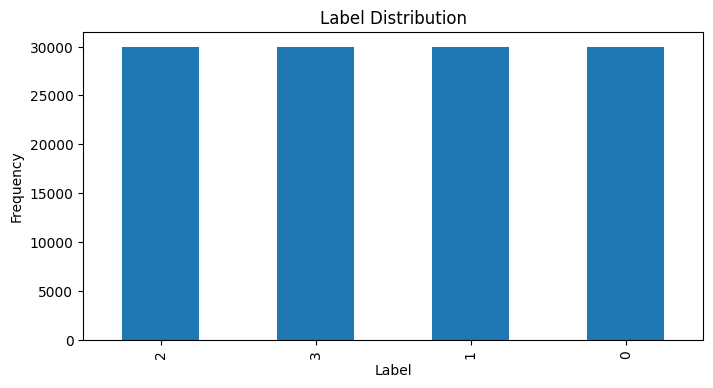

In [ ]:
train_data['label'].value_counts().plot(kind='bar', figsize=(8, 4))
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Label Distribution')

In [ ]:
spark = SparkSession.builder \
    .appName("Document Classification") \
    .getOrCreate()

# load data
train_pd = pd.read_csv('train.csv')
test_pd = pd.read_csv('test.csv')
# turn into dataframe
train_df = spark.createDataFrame(train_pd)
test_df = spark.createDataFrame(test_pd)

train_df.show(10)

+--------------------+-----+----------+
|                text|label|text_label|
+--------------------+-----+----------+
|Wall St. Bears Cl...|    2|  Business|
|Carlyle Looks Tow...|    2|  Business|
|Oil and Economy C...|    2|  Business|
|Iraq Halts Oil Ex...|    2|  Business|
|Oil prices soar t...|    2|  Business|
|Stocks End Up, Bu...|    2|  Business|
|Money Funds Fell ...|    2|  Business|
|Fed minutes show ...|    2|  Business|
|Safety Net (Forbe...|    2|  Business|
|Wall St. Bears Cl...|    2|  Business|
+--------------------+-----+----------+
only showing top 10 rows



In [ ]:
train_df.select('label').distinct().show()
train_df.printSchema()

+-----+
|label|
+-----+
|    0|
|    1|
|    3|
|    2|
+-----+

root
 |-- text: string (nullable = true)
 |-- label: long (nullable = true)
 |-- text_label: string (nullable = true)



In [ ]:
def preprocess_text(df):
    # int label
    df = df.withColumn('label', col('label').cast('int'))
    # remove punctuation
    df = df.withColumn('text', regexp_replace(col('text'), r'[^\w\s]', ''))
    # convert to lowercase
    df = df.withColumn('text', lower(col('text')))
    # tokenizer
    tokenizer = Tokenizer(inputCol='text', outputCol='words')
    df = tokenizer.transform(df)
    return df

train_df = preprocess_text(train_df)
test_df = preprocess_text(test_df)

train_df.show(10)

+--------------------+-----+----------+--------------------+
|                text|label|text_label|               words|
+--------------------+-----+----------+--------------------+
|wall st bears cla...|    2|  Business|[wall, st, bears,...|
|carlyle looks tow...|    2|  Business|[carlyle, looks, ...|
|oil and economy c...|    2|  Business|[oil, and, econom...|
|iraq halts oil ex...|    2|  Business|[iraq, halts, oil...|
|oil prices soar t...|    2|  Business|[oil, prices, soa...|
|stocks end up but...|    2|  Business|[stocks, end, up,...|
|money funds fell ...|    2|  Business|[money, funds, fe...|
|fed minutes show ...|    2|  Business|[fed, minutes, sh...|
|safety net forbes...|    2|  Business|[safety, net, for...|
|wall st bears cla...|    2|  Business|[wall, st, bears,...|
+--------------------+-----+----------+--------------------+
only showing top 10 rows



Sử dụng CountVectorizer

In [ ]:
def process_text_with_countvectorizer(df, countvectorizer_model=None):
    # countvectorizer
    if countvectorizer_model is None:
        countvectorizer = CountVectorizer(inputCol='words', outputCol='Features')
        countvectorizer_model = countvectorizer.fit(df)

    countvectorizer_df = countvectorizer_model.transform(df)
    countvectorizer_df = countvectorizer_df.select('label', 'Features')
    return countvectorizer_df, countvectorizer_model

countvectorizer_train_df, countvectorizer_model = process_text_with_countvectorizer(train_df)
countvectorizer_test_df, _ = process_text_with_countvectorizer(test_df, countvectorizer_model)

In [ ]:
countvectorizer_train_df.show(10)

+-----+--------------------+
|label|            Features|
+-----+--------------------+
|    2|(102182,[0,3,4,23...|
|    2|(102182,[0,2,3,4,...|
|    2|(102182,[0,3,4,6,...|
|    2|(102182,[0,2,3,5,...|
|    2|(102182,[0,1,2,3,...|
|    2|(102182,[0,2,3,7,...|
|    2|(102182,[0,1,3,4,...|
|    2|(102182,[0,2,3,5,...|
|    2|(102182,[0,1,2,3,...|
|    2|(102182,[0,3,4,16...|
+-----+--------------------+
only showing top 10 rows



Sử dụng TF-IDF

In [ ]:
def process_text_with_tfidf(df, idf_model=None):
    #tf-idf
    hashing_tf = HashingTF(inputCol='words', outputCol='rawFeatures', numFeatures=200000)
    tf = hashing_tf.transform(df)

    if idf_model is None:
        idf = IDF(inputCol='rawFeatures', outputCol='Features')
        idf_model = idf.fit(tf)

    tfidf = idf_model.transform(tf)
    tfidf = tfidf.select('label', 'Features')
    return tfidf, idf_model

# cặp dữ liệu (label, features)
tfidf_train_df, idf_model = process_text_with_tfidf(train_df)
tfidf_test_df, _ = process_text_with_tfidf(test_df, idf_model)

tfidf_train_df.show(10)

+-----+--------------------+
|label|            Features|
+-----+--------------------+
|    2|(200000,[10551,16...|
|    2|(200000,[7687,128...|
|    2|(200000,[6035,151...|
|    2|(200000,[6035,608...|
|    2|(200000,[6035,160...|
|    2|(200000,[5016,603...|
|    2|(200000,[1466,439...|
|    2|(200000,[1466,237...|
|    2|(200000,[2475,122...|
|    2|(200000,[10551,16...|
+-----+--------------------+
only showing top 10 rows



In [ ]:
nb = NaiveBayes(featuresCol='Features', labelCol='label', modelType='multinomial')

model_use_countvector = nb.fit(countvectorizer_train_df)
predictions_use_countvector = model_use_countvector.transform(countvectorizer_test_df)

model_use_tfidf = nb.fit(tfidf_train_df)
predictions_use_tfidf = model_use_tfidf.transform(tfidf_test_df)

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy_use_countvector = evaluator.evaluate(predictions_use_countvector)
print(f"Độ chính xác khi xử lí dữ liệu với Countvectorizer: {accuracy_use_countvector}")

accuracy_use_tfidf = evaluator.evaluate(predictions_use_tfidf)
print(f"Độ chính xác khi xử lí dữ liệu với TF-IDF: {accuracy_use_tfidf}")

Độ chính xác khi xử lí dữ liệu với Countvectorizer: 0.9007894736842105
Độ chính xác khi xử lí dữ liệu với TF-IDF: 0.904342105263158


In [ ]:
predictions_use_countvector.groupBy("label", "prediction").count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    2|       1.0|   18|
|    1|       0.0|   22|
|    0|       2.0|   92|
|    1|       3.0|   11|
|    3|       1.0|   18|
|    0|       3.0|   45|
|    0|       0.0| 1702|
|    1|       2.0|    6|
|    2|       3.0|  200|
|    3|       2.0|  139|
|    3|       3.0| 1672|
|    2|       2.0| 1611|
|    1|       1.0| 1861|
|    3|       0.0|   71|
|    2|       0.0|   71|
|    0|       1.0|   61|
+-----+----------+-----+



In [ ]:
predictions_use_tfidf.groupBy("label", "prediction").count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    2|       1.0|   19|
|    1|       0.0|   19|
|    0|       2.0|   93|
|    1|       3.0|   13|
|    3|       1.0|   10|
|    0|       3.0|   50|
|    0|       0.0| 1698|
|    1|       2.0|    6|
|    2|       3.0|  191|
|    3|       2.0|  139|
|    3|       3.0| 1688|
|    2|       2.0| 1625|
|    1|       1.0| 1862|
|    3|       0.0|   63|
|    2|       0.0|   65|
|    0|       1.0|   59|
+-----+----------+-----+



In [ ]:
def infer_countvector(text, true_label):
    data = [{'text': text, 'label': true_label}]
    text_df = spark.createDataFrame(data)
    text_df = preprocess_text(text_df)
    processed_text_df, _ = process_text_with_countvectorizer(text_df, countvectorizer_model)
    prediction = model_use_countvector.transform(processed_text_df)
    return prediction

def infer_tfidf(text, true_label):
    data = [{'text': text, 'label': true_label}]
    text_df = spark.createDataFrame(data)
    text_df = preprocess_text(text_df)
    processed_text_df, _ = process_text_with_tfidf(text_df, idf_model)
    prediction = model_use_tfidf.transform(processed_text_df)
    return prediction

Ví dụ về phân loại văn bản (infer)

In [ ]:
import random

total_rows = test_df.count()
random_index = random.randint(0, total_rows - 1)

sample_row = test_df.collect()[random_index]
sample_text = sample_row['text']
true_label = sample_row['label']

print(sample_text)
#infer
predicted_label_use_countvector = infer_countvector(sample_text, true_label)
predicted_label_use_tfidf = infer_tfidf(sample_text, true_label)

ferguson stirs the pot ahead of arsenal visit manchester united manager sir alex ferguson has raised the stakes before the carling cup clash with arsenal at old trafford by claiming that chelsea are now the team to beat


In [ ]:
predicted_label_use_countvector.groupBy("label", "prediction").count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       1.0|    1|
+-----+----------+-----+



In [ ]:
predicted_label_use_tfidf.groupBy("label", "prediction").count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       1.0|    1|
+-----+----------+-----+



# Sử dụng nhiều cụm

In [ ]:
spark_with_more_clusters = SparkSession.builder \
    .appName("Document Classification") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "16g") \
    .config("spark.executor.cores", "4") \
    .config("spark.executor.instances", "2") \
    .getOrCreate()

In [ ]:
# data = pd.DataFrame(newgroups.data, columns=['text'])
# data['label'] = newgroups.target
# data['label'] = data['label'].apply(lambda x: newgroups.target_names[x])

# # 1. Khởi tạo SparkSession
# spark = SparkSession.builder.appName("NaiveBayesWithMapReduce").getOrCreate()
# sc = spark.sparkContext

# # 2. Tải dữ liệu 20 Newsgroups từ scikit-learn (tất cả các lớp)
# newsgroups = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))

# # 3. Tiền xử lý dữ liệu: Sử dụng TfidfVectorizer thay vì CountVectorizer để nâng cao chất lượng đặc trưng
# vectorizer = TfidfVectorizer(max_features=2000)  # Tăng số lượng đặc trưng
# X = vectorizer.fit_transform(newsgroups.data)
# y = newsgroups.target

# # Chuyển đổi sang RDD cho PySpark
# data_rdd = sc.parallelize([(label, vector.toarray()[0]) for label, vector in zip(y, X)])

# # 4. MapReduce Implementation of Naive Bayes
# # Tính toán số lượng tài liệu và số lượng tài liệu cho mỗi lớp
# doc_count = data_rdd.map(lambda x: (x[0], 1)).reduceByKey(lambda a, b: a + b).collectAsMap()
# total_docs = sum(doc_count.values())

# # Tính toán xác suất tiên nghiệm P(y)
# priors = {k: v / total_docs for k, v in doc_count.items()}

# # Tính toán số lần xuất hiện của từ trong mỗi lớp
# word_counts = data_rdd.flatMap(lambda x: [((x[0], idx), val) for idx, val in enumerate(x[1])]) \
#                       .reduceByKey(lambda a, b: a + b)

# # Tính tổng số từ trong mỗi lớp
# total_word_counts = word_counts.map(lambda x: (x[0][0], x[1])).reduceByKey(lambda a, b: a + b).collectAsMap()

# # Tính xác suất có điều kiện P(x|y) với Laplace Smoothing (thêm 1 vào mỗi số đếm)
# conditional_probs = word_counts.map(lambda x: (x[0],
#     (x[1] + 1) / (total_word_counts[x[0][0]] + len(vectorizer.get_feature_names_out()))))

# # Chuyển đổi conditional_probs thành dạng dễ dùng
# conditional_probs = conditional_probs.collectAsMap()

# def predict(doc):
#     words = np.array(doc)
#     scores = {}
#     for c in priors:
#         score = np.log(priors[c])  # Log-likelihood để tránh underflow
#         for idx, count in enumerate(words):
#             score += count * np.log(conditional_probs.get((c, idx), 1e-6))  # Thêm smoothing cho các từ chưa xuất hiện
#         scores[c] = score
#     return max(scores, key=scores.get)

# # 6. Kiểm tra trên tập dữ liệu
# test_data = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))
# X_test = vectorizer.transform(test_data.data)
# y_test = test_data.target

# test_rdd = sc.parallelize([(label, vector.toarray()[0]) for label, vector in zip(y_test, X_test)])
# predictions = test_rdd.map(lambda x: (x[0], predict(x[1])))

# # 7. Tính độ chính xác
# accuracy = predictions.filter(lambda x: x[0] == x[1]).count() / test_rdd.count()
# print(f"Accuracy: {accuracy * 100:.2f}%")

# # 8. Kết thúc SparkSession
# spark.stop()